# Topic 3 Tensorflow Quanutm

## Install Tensorflow Quantum and Cirq

In [ ]:
!pip install tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [ ]:
!pip install cirq

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq

In [ ]:
tf.__version__

## Basic Cirq Operations

### Qubits

In [ ]:
# Create two qubits
q0 = cirq.GridQubit(0, 0)
q1 = cirq.GridQubit(1, 0)
print(q0,q1)

In [ ]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)
print(q0,q1)

In [ ]:
# Create two qubits
q0,q1 = cirq.LineQubit.range(2)
print(q0,q1)

#### Ex: Qubits

In [ ]:
q0, q1, q2 = [cirq.GridQubit(i, 0) for i in range(3)]
print(q0,q1,q2)

### Quantum Gates

In [ ]:
q0 = cirq.GridQubit(0, 0)
q1 = cirq.GridQubit(1, 0)

cirq.H(q0)
cirq.CNOT(q0, q1)

In [ ]:
print(cirq.unitary(cirq.X))
print(cirq.unitary(cirq.CNOT))

In [ ]:
print(cirq.measure(q0,q1))

#### Ex: Quantum Gates

In [ ]:
q0, q1, q2 = [cirq.GridQubit(i, 0) for i in range(3)]

cirq.H(q0)
cirq.CNOT(q0, q1)
cirq.CNOT(q0, q2)
print(cirq.measure(q0,q1,q2))

### Quantum Circuits

In [ ]:
q0, q1 = cirq.LineQubit.range(2)

circuit = cirq.Circuit()
# circuit.append([cirq.H(q0)), cirq.X(q1), cirq.CNOT(q0, q1)])
circuit.append(cirq.H(q0))
circuit.append(cirq.X(q1))
circuit.append(cirq.CNOT(q0, q1))
circuit.append(cirq.measure(q0,q1))
print(circuit)

#### Ex: Quantum Circuits

In [ ]:
q0, q1, q2 = cirq.LineQubit.range(3)

circuit = cirq.Circuit()
circuit.append(cirq.H(q0))
circuit.append(cirq.CNOT(q0, q1))
circuit.append(cirq.CNOT(q0, q2))
circuit.append(cirq.measure(q0,q1,q2))
print(circuit)

### Simulator

In [ ]:
# Create a circuit to generate a Bell State:
# sqrt(2) * ( |00> + |11> )
bell_circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit.range(2)

bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0,q1))
print(bell_circuit)

simulator=cirq.Simulator()
results=simulator.simulate(bell_circuit)
print(results)

bell_circuit.append(cirq.measure(q0, q1))
results =simulator.run(bell_circuit, repetitions=1000)
print(cirq.plot_state_histogram(results))


#### Ex: Simulator

In [ ]:
bell_circuit = cirq.Circuit()
q0, q1,q2  = cirq.LineQubit.range(3)

bell_circuit.append(cirq.H(q0))
bell_circuit.append(cirq.CNOT(q0,q1))
bell_circuit.append(cirq.CNOT(q0,q2))
print(bell_circuit)

simulator=cirq.Simulator()
results=simulator.simulate(bell_circuit)
print(results)

bell_circuit.append(cirq.measure(q0,q1,q2))
results =simulator.run(bell_circuit, repetitions=1000)
print(cirq.plot_state_histogram(results))

### Parametrized Circuit

In [ ]:
import matplotlib.pyplot as plt
import sympy
import numpy as np

q = cirq.GridQubit(1,1)
theta = sympy.symbols('theta')
circuit = cirq.Circuit(cirq.rx(theta).on(q), cirq.measure(q, key='m'))

param_sweep = cirq.Linspace('theta', start=0, stop=np.pi, length=100)

# Simulate the sweep
simulator = cirq.Simulator()
trials = simulator.run_sweep(circuit, param_sweep, repetitions=1000)

# Plot all the results
x = [trial.params['theta'] for trial in trials]
y = [trial.histogram(key='m')[1] / 1000.0 for trial in trials]
plt.scatter(x,y)
plt.xlabel('theta')
plt.ylabel('probability of |1>')

# Topic 4 Quantum Machine Learning

### Convert to Tensor

In [50]:
q0, q1 = cirq.GridQubit.rect(1, 2)

circuit = cirq.Circuit()
circuit.append(cirq.H(q0))
circuit.append(cirq.X(q1))
circuit.append(cirq.CNOT(q0, q1))
circuit.append(cirq.measure(q0,q1))

tensor_circuit = tfq.convert_to_tensor([circuit])
result = outputs(tensor_circuit)
print(result)
# same_circuits = tfq.from_tensor(tensor_circuit)
# print(same_circuits)

tf.Tensor([[1.8408706e-07]], shape=(1, 1), dtype=float32)


### Parametrized Quantum Circuit (PQC) Layer.

In [64]:
q = cirq.GridQubit(0, 0)
(a, b, c) = sympy.symbols("a b c")
circuit = cirq.Circuit(
    cirq.rz(a)(q),
    cirq.rx(b)(q),
    cirq.rz(c)(q)
)
measurement = [cirq.X(q), cirq.Y(q), cirq.Z(q)]
outputs = tfq.layers.PQC(circuit,measurement)
quantum_data = tfq.convert_to_tensor([cirq.Circuit(),cirq.Circuit(cirq.X(q))])
res = outputs(quantum_data)
res.numpy()

array([[ 0.23841469, -0.8694439 , -0.4326962 ],
       [-0.23841463,  0.86944395,  0.43269598]], dtype=float32)

### State Vector

In [59]:
q0, q1 = cirq.GridQubit.rect(1, 2)
bell_circuit = cirq.Circuit(cirq.H(q0), cirq.CNOT(q0, q1))
state_layer = tfq.layers.State()
state_layer(bell_circuit)

Instructions for updating:
reduction_indices is deprecated, use axis instead


<tf.RaggedTensor [[(0.7071067690849304-1.2802768623032534e-08j), 0j, (1.3510586319685509e-15-3.0908619663705394e-08j), (0.7071067690849304+6.181723932741079e-08j)]]>

## Hybrid Quantum-Classical Optimization

In [60]:
import cirq
import numpy as np
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

#### Step 1: Generate Quantum Dataset

In [61]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  q_data = []
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  for _ in range(num_samples):
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"
    labels.append(label)
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), cirq.rx(-spread_x)(qubit)))
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

#Genrate the dataset
qubit = cirq.GridQubit(0, 0)
theta_a = 1
theta_b = 4
num_samples = 200
q_data, labels, bloch_p = generate_dataset(qubit, theta_a, theta_b, num_samples)

#### Step 2 Quantum Classicl Model

In [ ]:
#We will use a parameterized rotation about the Y axis followed by a Z-axis measurement as the quantum portion of our model.
#For the classical portion, we will use a two-unit SoftMax which should learn to distinguish the measurement statistics of the two data sources.

# Build the quantum model layer
theta = sympy.symbols('theta')
q_model = cirq.Circuit(cirq.ry(theta)(qubit))
q_data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
expectation_output = expectation(q_data_input)

# Attach the classical SoftMax classifier
classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
classifier_output = classifier(expectation_output)
model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)


#### Training

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer,loss='categorical_crossentropy')
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(x=q_data, y=labels, epochs=50)

In [ ]:
import matplotlib.pyplot as plt

loss=history.history['loss']
epoch=range(50)

plt.plot(epoch,loss)
plt.xlabel('epoch')
plt.ylabel('loss')

#### Testing

In [ ]:
test_data, _, _ = generate_dataset(qubit, theta_a, theta_b, 1)
p = model.predict(test_data)[0]
print(f"prob(a)={p[0]:.4f}, prob(b)={p[1]:.4f}")

## Second Example of Quantum Classical Model

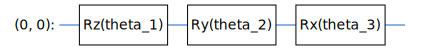

In [17]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

In [18]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [19]:
# This input is the simulated miscalibration that the model will learn to correct.
circuits_input = tf.keras.Input(shape=(),dtype=tf.string,name='circuits_input')

# Commands will be either `0` or `1`, specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),dtype=tf.dtypes.float32,name='commands_input')

In [20]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit, operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

In [21]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

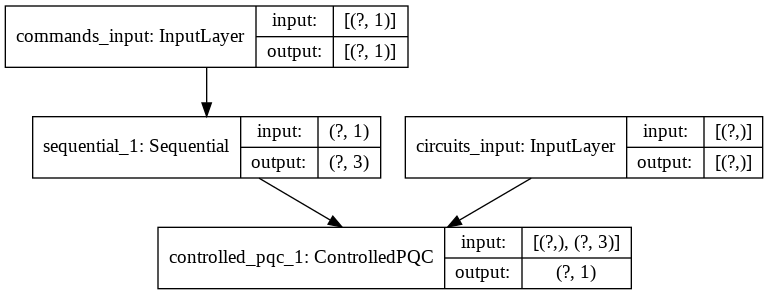

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [24]:
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],y=expected_outputs,epochs=30)

Train on 2 samples
Epoch 1/30
2/2 [==============================] - 1s 318ms/sample - loss: 0.5220
Epoch 2/30
2/2 [==============================] - 0s 4ms/sample - loss: 0.2536
Epoch 3/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.1265
Epoch 4/30
2/2 [==============================] - 0s 3ms/sample - loss: 0.0566
Epoch 5/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0181
Epoch 6/30
2/2 [==============================] - 0s 2ms/sample - loss: 0.0036
Epoch 7/30
2/2 [==============================] - 0s 3ms/sample - loss: 3.4535e-04
Epoch 8/30
2/2 [==============================] - 0s 3ms/sample - loss: 1.6948e-05
Epoch 9/30
2/2 [==============================] - 0s 3ms/sample - loss: 4.1973e-05
Epoch 10/30
2/2 [==============================] - 0s 3ms/sample - loss: 5.1062e-04
Epoch 11/30
2/2 [==============================] - 0s 3ms/sample - loss: 0.0021
Epoch 12/30
2/2 [==============================] - 0s 3ms/sample - loss: 0.0050
Epoch 13/30


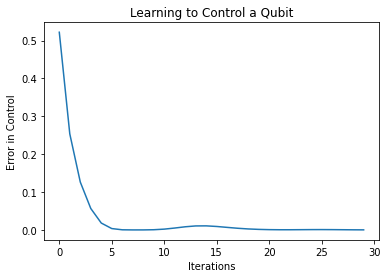

In [26]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()